### Xiaoxia Lin

----------------------------------------------------------------------------------------------


This function performs the orthogonal projection of the vector "gradient" over the hyperplane constructed from vector "y" and the fact that we are currently located at certain sides of the constraint cube $ 0 \leq \alpha_i \leq C$. This function will be used later on.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys

def orthogonal_projection(gradient, y, sides):
    import sys
    import numpy as np

    m = y.size
    if (len(sides) > m):
        sys.exit("Error: len(sides) > m")

    # We normalize y. We use a vector y equal to zeros to simulate no hyperplane
    norm = np.linalg.norm(y)
    y_normalized = y.copy()
    if not (norm <= 1e-10):
        y_normalized = y_normalized / np.linalg.norm(y)

    # We now apply the Gram-Schmidt algorithm to construct the projection subspace S
    c_ortho = np.zeros((len(sides),m))
    for i in range(len(sides)):
        c_ortho[i,sides[i]] = 1.0;
        c_ortho[i,:] = c_ortho[i,:] - np.dot(c_ortho[i,:], y_normalized) * y_normalized
        for j in range(0,i):
            c_ortho[i,:] = c_ortho[i,:] - np.dot(c_ortho[i,:], c_ortho[j,:]) * c_ortho[j,:]
        c_ortho[i,:] = c_ortho[i,:] / np.linalg.norm(c_ortho[i,:])
        
    # This is the gradient projection orthogonal to the subspace S constructed previously
    g_project = gradient.copy()
    g_project = g_project - np.dot(g_project, y_normalized) * y_normalized
    for i in range(len(sides)):
        g_project = g_project - np.dot(g_project, c_ortho[i,:]) * c_ortho[i,:]  
        
    return g_project

We begin with an example. Compute the values of a quadratic form and plot it. We also plot the restrition cube.

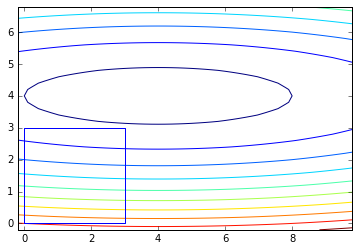

In [2]:
# These are the constraints. Please do not set to a high value for the moment.
C=3.0

# Let us construct a quadratic function 0.5 * x^T * A * x - h^T * x
A = np.identity(2)
A[1,1]=20.0
h = np.array([4, 80])

# Let us plot the function. Observe that "x1" is horizontal in the plot,
# whereas "x2" is respectively vertical.
x1 = np.arange(-0.2, 10.0, 0.2)
x2 = np.arange(-0.2, 7.0, 0.2)

X1, X2 = np.meshgrid(x1, x2)

Z = np.zeros((x2.size, x1.size))

for i in range(x2.size):
    for j in range(x1.size):
        x_tmp = np.array([x1[j],x2[i]])
        z_tmp = 0.5 * np.dot(x_tmp,np.dot(A,x_tmp)) - np.dot(h,x_tmp)
        Z[i,j] = z_tmp
        
fig = plt.figure()
plt.contour(X1, X2, Z, 10)

# Plot the restriction cube
plt.plot([0, 0, C, C, 0], [0, C, C, 0, 0])

We now perform a test with the computation of the optimum value of beta, the search step. Here you may test with the initial point and a search direction. The search direction does not have to be a descent direction. If it is not a descent direction, the value of beta will be negative.

The optimum value of beta is 6.41666666667


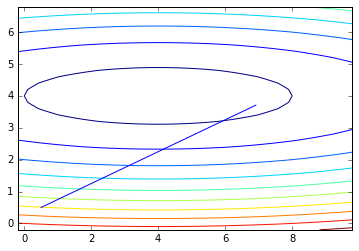

In [3]:
# Initial point
alpha_0 = np.array([0.5,0.5])

# The desent direction. First the x1 component, then the x2 component
# Try here different values!
descent = np.array([1.0,0.5])
                     
# Let us compute the maximum step that we may take. The equation
# is given in the lab document
p = descent.copy()
beta_opt_denominator = np.dot(p,np.dot(A,p))
beta_opt_numerator   = np.dot(p,h - np.dot(A,alpha_0))
beta_opt = (beta_opt_numerator / beta_opt_denominator)

print "The optimum value of beta is", beta_opt

# This is the new point
alpha_1 = alpha_0 + beta_opt * p

# Plot it!!!
fig = plt.figure()
plt.contour(X1, X2, Z, 10)
plt.plot([alpha_0[0], alpha_1[0]], [alpha_0[1], alpha_1[1]])

This is an example in which we show how to perform a gradient descent restricted to a particular cube. Here no hyperplane "y" is constructed. We simulate the latter effect by setting y = np.array([0, 0]) (see function orthogonal_projection since the code has been adapted to take this case into account).

Iteration 1
   Descent is [  3.5  70. ]
   beta_opt is 0.0501187351581
   beta_max is 0.0357142857143
Iteration 2
   Descent is [ 3.375  0.   ]
   beta_opt is 1.0
   beta_max is 0.703703703704
Iteration 3
   Descent is [ 0.  0.]
Norm of p very small! Finished!


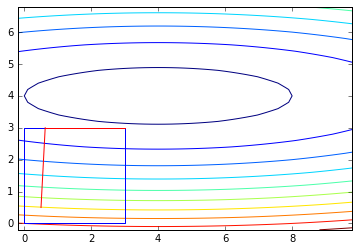

In [4]:
# Initial point. The initial point should be inside the cube
alpha = np.array([0.5,0.5])

# This are the restictions of the cube. Currently no restrictions since
# we are inside the cube
sides = []

# We initialize the effect of no hyperplane (see the code orthogonal_projection)
y = np.array([0, 0])
m = y.size

# We plot the function and the restriction cube
fig = plt.figure()
plt.contour(X1, X2, Z, 10)
plt.plot([0, 0, C, C, 0], [0, C, C, 0, 0])

# Iterations
cont = 0
while (cont < 100):
    cont=cont+1
    print "Iteration", cont
    
    # Gradient of the quadratic form
    gradient = np.dot(A, alpha) - h
    descent  = - gradient.copy()
    
    # This is the search direction, that is, the gradient projected taking into 
    # account the restriction of the cube
    p = orthogonal_projection(descent, y, sides)
    
    # We manually set to zero the search direction if we are on side "i"
    for i in sides:
        p[i] = 0.0
    print "   Descent is", p
        
    # Compute the norm of p. Just to be sure that we can move. 
    norm = np.linalg.norm(p)
    if (norm < 1e-10):
        print "Norm of p very small! Finished!"
        break

    # Compute the optimum value of beta, the search step
    beta_opt_denominator = np.dot(p, np.dot(A,p))
    beta_opt_numerator   = np.dot(p, h - np.dot(A,alpha)) 
    beta_opt = (beta_opt_numerator / beta_opt_denominator)
    
    print "   beta_opt is", beta_opt
    
    # Which is the maximum value of beta that can be taken?
    # Since the function to minimize is quadratic we have to add 
    # new elements to sides (i.e. no elements are removed from sides)
    beta_max = beta_opt
    for i in range(m):
        if not i in sides:
            if (p[i] > 0):    # We move to the upper face of the restriction
                beta_tmp = (C - alpha[i]) / p[i]
            elif (p[i] < 0):  # We move to the lower face of the restriction
                beta_tmp = ( - alpha[i] ) / p[i]
                
            if (beta_tmp < beta_max):
                beta_max = beta_tmp
                sides.extend([i])
                
    print "   beta_max is", beta_max
                
    # Update the value of alpha            
    alpha_new = alpha + beta_max * p
    
    # Plot
    plt.plot([alpha[0], alpha_new[0]], [alpha[1], alpha_new[1]], 'r')
    
    # Update
    alpha = alpha_new  

## Simple dataset (well separated)

The problem has 160 training elements
Norm of p very small! Finished!
w= [ 0.50886542  0.61665567]
b= -1.6190521379


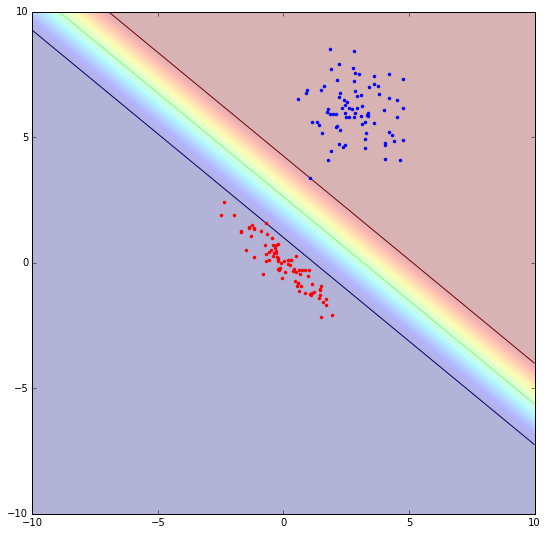

In [5]:
# Try this first!!! We have one sample for each class!!!
# c1 = np.array([[0.5, 0.3]])
# c2 = np.array([[5.0, 6.0]])

# Once the previous works, try with this
# Generate random data. The next code is of Oriols' notebook.
m1 = [0.,0.]
s1 = [[1,-0.9],[-0.9,1]]
m2 = [3.,6.]
s2 = [[1,0],[0,1]]
c1 = np.random.multivariate_normal(m1,s1,80)
c2 = np.random.multivariate_normal(m2,s2,80)

# Perform the plot
fig = plt.figure()
plt.plot(c1[:,0],c1[:,1],'r.')
plt.plot(c2[:,0],c2[:,1],'b.')
plt.xlim([-10, 10])
plt.ylim([-10, 10])

# We concatenate the data of c1 and c2. Take into account that variable "y" is our hyperplane. 
x = np.r_[c1,c2].T
y = np.r_[-np.ones(c1.shape[0]),np.ones(c2.shape[0])]

# Let us now construct matrices X and Y as explained in the lab document.
m = y.size
print "The problem has", m, "training elements"
X = x
Y = np.diag(y)

# This is the restriction cube. You may use different values of C.
C = 100000.0
#C = 1.
sides = []
               
# Our initial values for alpha. The initial point has to be over the hyperplane
alpha = np.empty(m)
alpha.fill(0.0)    
               
# Construct matrices A and h in order to be able to use the code from this notebook! 
# We are going to minimize the quadratic function: f(alpha) = 0.5 * alpha^T * A * alpha - h^T * alpha 

# 1) ----------------------------- TODO TODO: PUT YOUR CODE HERE!!! --------------------------------
A = np.dot(Y,np.dot(X.T, np.dot(X,Y)))
h = np.ones((m,1)).ravel()


# Perform now the iterations.               
# 2) -------------------------------TODO TODO: PUT YOUR CODE HERE!!!-------------------------------

# Iterations
cont = 0
while (cont < 100):
    cont=cont+1

    # Gradient of the quadratic form: f(alpha) = 0.5 * alpha^T * A * alpha - h^T * alpha 
    gradient = np.dot(A, alpha) - h
    descent  = - gradient.copy()
    
    # search direction
    p = orthogonal_projection(descent, y, sides)
    
    # We manually set to zero the search direction if we are on side "i"
    for i in sides:
        p[i] = 0.0
        
    # Compute the norm of p. Just to be sure that we can move. 
    norm = np.linalg.norm(p)
    if (norm < 1e-10):
        print "Norm of p very small! Finished!"
        break

    # Compute the optimum value of beta, the search step
    beta_opt_denominator = np.dot(p, np.dot(A,p))
    beta_opt_numerator   = np.dot(p, h - np.dot(A,alpha)) 
    beta_opt = (beta_opt_numerator / beta_opt_denominator)
    #print "   beta_opt is", beta_opt
    
    # Which is the maximum value of beta that can be taken?
    # Since the function to minimize is quadratic we have to add 
    # new elements to sides (i.e. no elements are removed from sides)
    beta_max = beta_opt
    for i in range(m):
        if not i in sides:
            if (p[i] > 0):    # We move to the upper face of the restriction
                beta_tmp = (C - alpha[i]) / p[i]
            elif (p[i] < 0):  # We move to the lower face of the restriction
                beta_tmp = ( - alpha[i] ) / p[i]
                
            if (beta_tmp < beta_max):
                beta_max = beta_tmp
                sides.extend([i])            
    #print "   beta_max is", beta_max
                
    # Update the value of alpha            
    alpha_new = alpha + beta_max * p
    
    # Plot
    #plt.plot([alpha[0], alpha_new[0]], [alpha[1], alpha_new[1]], 'r')
    
    # Update
    alpha = alpha_new  
#print "alpha=",alpha
               
# Once iterations are finished, recover the value of w and b.
# The equations are indicated in the document.              
# 3)------------------------------- TODO TODO: PUT YOUR CODE HERE!!!-------------------------------

w = np.dot(X,Y.dot(alpha))
print "w=", w

for i in range(y.shape[0]):
    if alpha[i]>1e-2 and alpha[i]<C: b = y[i] - w.T.dot(x.T[i]) 
print "b=", b
               
# Some plot would be fine              
# 4) -------------------------------TODO TODO: PUT YOUR CODE HERE!!!-------------------------------

xx,yy = np.meshgrid(np.linspace(-10,10,200),np.linspace(-10,10,200))
viz=np.c_[xx.ravel(),yy.ravel()]
z = np.dot(viz,w)+b

plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-10,10,-10,10),alpha=0.3, vmin=-1, vmax=1)
plt.contour(xx,yy,z.reshape((200,200)),[-1.,0.,1.])
plt.gcf().set_size_inches((9,9))


0.398808368605
[[ 0.54872176]
 [ 0.57887554]]
-1.53290652149


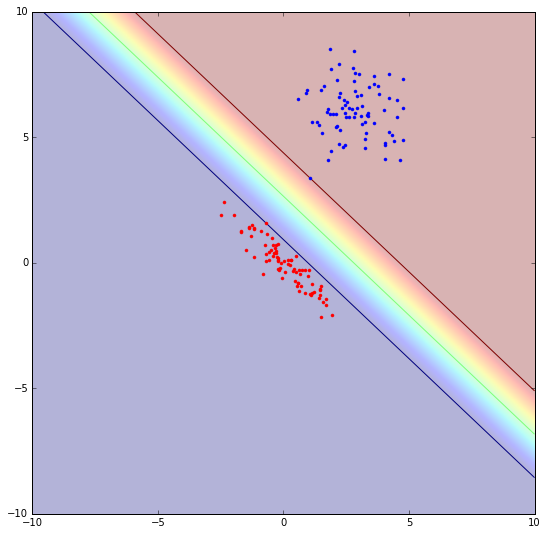

In [6]:
# Check the result with the code in Oriol's notebook 
# Solve 

from cvxpy import *
import numpy

d = x.shape[0]
N = x.shape[1]

# Construct the problem.
a = Variable(d)
b = Variable()
error = norm(a)/2.
obj = Minimize(error)
constraints = [mul_elemwise(y.T,x.T*a+b)>=1]
prob = Problem(obj,constraints)
print prob.solve()

# plot

xx,yy = np.meshgrid(np.linspace(-10,10,200),np.linspace(-10,10,200))
viz=np.c_[xx.ravel(),yy.ravel()]
print a.value
print b.value

z = np.dot(viz,a.value)+b.value

plt.plot(c1[:,0],c1[:,1],'r.')
plt.plot(c2[:,0],c2[:,1],'b.')
plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-10,10,-10,10),alpha=0.3, vmin=-1, vmax=1)
plt.contour(xx,yy,z.reshape((200,200)),[-1.,0.,1.])

plt.gcf().set_size_inches((9,9))

##  non-separable case

(2, 30) (30,)
The problem has 30 training elements
alpha [  2.19579754e+00   4.59543260e-03   9.63379519e-01   6.17731589e-03
   8.15594586e-03   0.00000000e+00   0.00000000e+00   8.57367003e+00
   1.17571086e+00   3.45018906e+00   3.83626838e+00   0.00000000e+00
   5.10317000e+00   8.09894212e+00   1.39789010e+00   0.00000000e+00
   0.00000000e+00   8.28517658e+00   5.03152268e+00   8.62028284e-01
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.22457104e+01
   8.77723076e+00   0.00000000e+00   0.00000000e+00   5.13234139e+00
   5.26562089e+00   1.75717704e+01] 97.9853476628
w= [ 0.76147056  1.3553605 ]
b= 1.13064388838


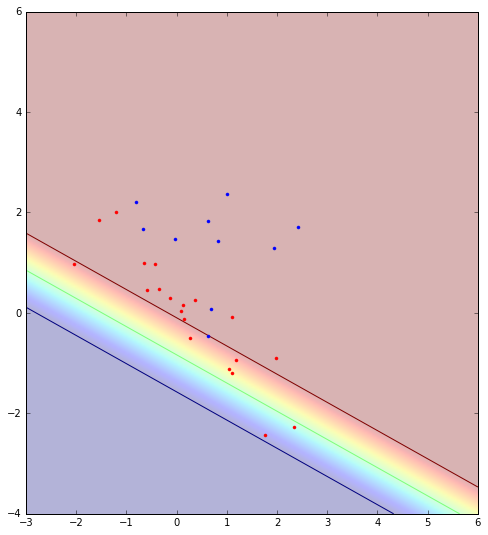

In [7]:
%matplotlib inline
import numpy as np
m1 = [0.,0.]
s1 = [[1,-0.9],[-0.9,1]]
m2 = [1.,1.]
s2 = [[1,0],[0,1]]
c1 = np.random.multivariate_normal(m1,s1,20)
c2 = np.random.multivariate_normal(m2,s2,10)

x= np.r_[c1,c2].T
y= np.r_[-np.ones(c1.shape[0]),np.ones(c2.shape[0])].T
print x.shape,y.shape

import matplotlib.pyplot as plt
plt.plot(c1[:,0],c1[:,1],'r.')
plt.plot(c2[:,0],c2[:,1],'b.')

# We concatenate the data of c1 and c2. Take into account that variable "y" is our hyperplane. 
x = np.r_[c1,c2].T
y = np.r_[-np.ones(c1.shape[0]),np.ones(c2.shape[0])]

# Let us now construct matrices X and Y as explained in the lab document.
m = y.size
print "The problem has", m, "training elements"
X = x
Y = np.diag(y)

# This is the restriction cube. You may use different values of C.
C = 1000.0  
sides = []
               
# Our initial values for alpha. The initial point has to be over the hyperplane
alpha = np.empty(m)
alpha.fill(0.0)    
               
# Construct matrices A and h in order to be able to use the code
# from this notebook! We are going to minimize the quadratic function 
# f(alpha) = 0.5 * alpha^T * A * alpha - h^T * alpha 
# 1) --------- TODO TODO: PUT YOUR CODE HERE!!! ----------------------------------------------
A = np.dot(Y,np.dot(X.T, np.dot(X,Y)))
h = np.ones((m,1)).ravel()


# Perform now the iterations.               
# 2) -------------------------------TODO TODO: PUT YOUR CODE HERE!!!-------------------------------

# Iterations
cont = 0
while (cont < 100):
    cont=cont+1
    #print "Iteration", cont
    
    # Gradient of the quadratic form
    gradient = np.dot(A, alpha) - h
    descent  = - gradient.copy()
    
    # This is the search direction, that is, the gradient projected taking into 
    # account the restriction of the cube
    p = orthogonal_projection(descent, y, sides)
    
    # We manually set to zero the search direction if we are on side "i"
    for i in sides:
        p[i] = 0.0
        
    #print "   Descent is", p
        
    # Compute the norm of p. Just to be sure that we can move. 
    norm = np.linalg.norm(p)
    if (norm < 1e-10):
        print "Norm of p very small! Finished!"
        break

    # Compute the optimum value of beta, the search step
    beta_opt_denominator = np.dot(p, np.dot(A,p))
    beta_opt_numerator   = np.dot(p, h - np.dot(A,alpha)) 
    beta_opt = (beta_opt_numerator / beta_opt_denominator)
    
    #print "   beta_opt is", beta_opt
    
    # Which is the maximum value of beta that can be taken?
    # Since the function to minimize is quadratic we have to add 
    # new elements to sides (i.e. no elements are removed from sides)
    beta_max = beta_opt
    for i in range(m):
        if not i in sides:
            if (p[i] > 0):    # We move to the upper face of the restriction
                beta_tmp = (C - alpha[i]) / p[i]
            elif (p[i] < 0):  # We move to the lower face of the restriction
                beta_tmp = ( - alpha[i] ) / p[i]
                
            if (beta_tmp < beta_max):
                beta_max = beta_tmp
                sides.extend([i])            
    #print "   beta_max is", beta_max
                
    # Update the value of alpha            
    alpha_new = alpha + beta_max * p
    
    # Plot
    #plt.plot([alpha[0], alpha_new[0]], [alpha[1], alpha_new[1]], 'r')
    
    # Update
    alpha = alpha_new  
print "alpha",alpha,sum(alpha)
               
# Once iterations are finished, recover the value of w and b.
# The equations are indicated in the document.              
# 3)------------------------------- TODO TODO: PUT YOUR CODE HERE!!!-------------------------------

w = np.dot(X,Y.dot(alpha))
print "w=", w

for i in range(y.shape[0]):
    if alpha[i]>1e-2 and alpha[i]<C: b = y[i] - w.T.dot(x.T[i])     
print "b=", b
               
# Some plot would be fine              
# 4) -------------------------------TODO TODO: PUT YOUR CODE HERE!!!-------------------------------
xx,yy = np.meshgrid(np.linspace(-3,6,200),np.linspace(-4,6,200))
viz=np.c_[xx.ravel(),yy.ravel()]
z = np.dot(viz,w)+b
plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-3,6,-4,6),alpha=0.3, vmin=-1, vmax=1)
plt.contour(xx,yy,z.reshape((200,200)),[-1.,0.,1.])
plt.gcf().set_size_inches((9,9))


[[ 1.94530057]
 [ 2.42502829]] -2.50475938053


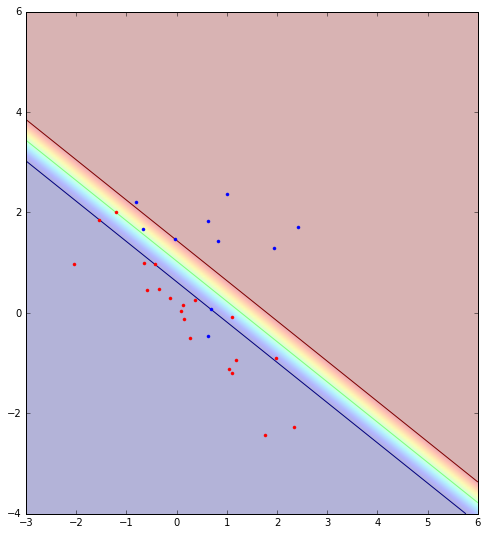

In [8]:
# solve for w and b

from cvxpy import *
import numpy

d = x.shape[0]
N = x.shape[1]
C = 1000.0 

# Construct the problem.
a = Variable(d)
b = Variable()
epsilon = Variable(N)    # pareto's optimal: chi

error = norm(a) + C*sum(epsilon)
obj = Minimize(error)
constraints = [mul_elemwise(y.T,x.T*a+b)>=1-epsilon,epsilon>=0]
prob = Problem(obj,constraints)
prob.solve()
print a.value,b.value


# plot 
xx,yy = np.meshgrid(np.linspace(-3,6,200),np.linspace(-4,6,200))
viz=np.c_[xx.ravel(),yy.ravel()]

z = np.dot(viz,a.value)+b.value

plt.plot(c1[:,0],c1[:,1],'r.')
plt.plot(c2[:,0],c2[:,1],'b.')
plt.gca().set_xlim([-3.,6.])
plt.gca().set_ylim([-4.,6.])
plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-3,6,-4,6),alpha=0.3, vmin=-1, vmax=1)
plt.contour(xx,yy,z.reshape((200,200)),[-1.,0.,1.])

plt.gcf().set_size_inches((9,9))